In [42]:
!pip install langchain langgraph rich python-dotenv pydantic typing_extensions tenacity tavily-python sqlite-utils

In [43]:
!pip -q install -U langchain langchain-google-genai pydantic python-dotenv

In [44]:
!pip install langgraph-checkpoint-sqlite

In [45]:
# Importing Libraries
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
from rich.markdown import Markdown
from rich.table import Table
import json, time, sqlite3, os, operator
from typing_extensions import Optional, Annotated, Sequence, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command
from datetime import datetime
from langchain.chat_models import init_chat_model
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

In [ ]:
console = Console()
os.environ['GOOGLE_API_KEY'] = "API_KEY"
model = init_chat_model("gemini-2.5-flash-lite", model_provider="google_genai", temperature=0)

In [47]:
# UI Helper
def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """Display a prompt with rich formatting and XML tag highlighting."""
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r'<[^>]+>', style="bold blue")
    formatted_text.highlight_regex(r'##[^#\n]+', style="bold magenta")
    formatted_text.highlight_regex(r'###[^#\n]+', style="bold cyan")

    console.print(Panel(
        formatted_text,
        title=f"[bold green]{title}[/bold green]",
        border_style=border_style,
        padding=(1, 2)
    ))

def format_message_content(message):
    """Convert message content (text + tool calls) to displayable string."""
    parts, tool_calls_processed = [], False
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))

    # Handle OpenAI style tool calls
    if not tool_calls_processed and hasattr(message, 'tool_calls') and message.tool_calls:
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2)}")

    return "\n".join(parts)

def format_messages(messages):
    """Display messages with Rich panels by type."""
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message', '')
        content = format_message_content(m)
        border_styles = {"Human": "blue", "Ai": "green", "Tool": "yellow"}
        title_icons = {"Human": " Human", "Ai": " Assistant", "Tool": " Tool Output"}
        console.print(Panel(content, title=title_icons.get(msg_type, " Other"), border_style=border_styles.get(msg_type, "white")))



In [48]:
# METRICS UTILITIES
def get_conversation_metrics(messages):
    human_msgs = [m for m in messages if m.__class__.__name__=="HumanMessage"]
    ai_msgs = [m for m in messages if m.__class__.__name__=="AIMessage"]
    return {
        "total_messages": len(messages),
        "human_count": len(human_msgs),
        "ai_count": len(ai_msgs),
        "avg_human_length": sum(len(m.content) for m in human_msgs)/max(1,len(human_msgs)),
        "avg_ai_length": sum(len(m.content) for m in ai_msgs)/max(1,len(ai_msgs)),
    }

def specificity_score(text):
    keywords = ["specific","example","detail","data","report"]
    return sum(k in text.lower() for k in keywords)/len(keywords)

def log_metrics(run_id, metrics: dict):
    conn = sqlite3.connect("research_agent.sqlite")
    c = conn.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS metrics
                 (run_id TEXT, key TEXT, value REAL)""")
    for k,v in metrics.items():
        c.execute("INSERT INTO metrics VALUES (?,?,?)", (run_id, k, v))
    conn.commit()
    conn.close()

def show_metrics(metrics):
    table = Table(title="Run Metrics")
    table.add_column("Metric", style="cyan")
    table.add_column("Value", style="magenta")
    for k,v in metrics.items():
        val = str(round(v,2) if isinstance(v,(int,float)) else v)
        table.add_row(k, val)
    console.print(table)

def timed_invoke(model, msgs):
    start = time.time()
    response = model.invoke(msgs)
    elapsed = round(time.time() - start, 2)
    return response, elapsed



In [49]:
# PROMPT STRINGS
clarify_with_user_instructions = """
These are the messages that have been exchanged so far from the user asking for the report:
<Messages>
{messages}
</Messages>

Today's date is {date}.

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.
IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.

If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.
If you need to ask a question, follow these guidelines:
- Be concise while gathering all necessary information
- Make sure to gather all the information needed to carry out the research task in a concise, well-structured manner.
- Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown formatting and will be rendered correctly if the string output is passed to a markdown renderer.
- Don't ask for unnecessary information, or information that the user has already provided. If you can see that the user has already provided the information, do not ask for it again.

Respond in valid JSON format with these exact keys:
"need_clarification": boolean,
"question": "<question to ask the user to clarify the report scope>",
"verification": "<verification message that we will start research>"

If you need to ask a clarifying question, return:
"need_clarification": true,
"question": "<your clarifying question>",
"verification": ""

If you do not need to ask a clarifying question, return:
"need_clarification": false,
"question": "",
"verification": "<acknowledgement message that you will now start research based on the provided information>"

For the verification message when no clarification is needed:
- Acknowledge that you have sufficient information to proceed
- Briefly summarize the key aspects of what you understand from their request
- Confirm that you will now begin the research process
- Keep the message concise and professional
"""

transform_messages_into_research_topic_prompt = """You will be given a set of messages that have been exchanged so far between yourself and the user.
Your job is to translate these messages into a more detailed and concrete research question that will be used to guide the research.

The messages that have been exchanged so far between yourself and the user are:
<Messages>
{messages}
</Messages>

Today's date is {date}.

You will return a single research question that will be used to guide the research.

Guidelines:
1. Maximize Specificity and Detail
- Include all known user preferences and explicitly list key attributes or dimensions to consider.
- It is important that all details from the user are included in the instructions.

2. Handle Unstated Dimensions Carefully
- When research quality requires considering additional dimensions that the user hasn't specified, acknowledge them as open considerations rather than assumed preferences.
- Example: Instead of assuming "budget-friendly options," say "consider all price ranges unless cost constraints are specified."
- Only mention dimensions that are genuinely necessary for comprehensive research in that domain.

3. Avoid Unwarranted Assumptions
- Never invent specific user preferences, constraints, or requirements that weren't stated.
- If the user hasn't provided a particular detail, explicitly note this lack of specification.
- Guide the researcher to treat unspecified aspects as flexible rather than making assumptions.

4. Distinguish Between Research Scope and User Preferences
- Research scope: What topics/dimensions should be investigated (can be broader than user's explicit mentions)
- User preferences: Specific constraints, requirements, or preferences (must only include what user stated)
- Example: "Research coffee quality factors (including bean sourcing, roasting methods, brewing techniques) for San Francisco coffee shops, with primary focus on taste as specified by the user."

5. Use the First Person
- Phrase the request from the perspective of the user.

6. Sources
- If specific sources should be prioritized, specify them in the research question.
- For product and travel research, prefer linking directly to official or primary websites (e.g., official brand sites, manufacturer pages, or reputable e-commerce platforms like Amazon for user reviews) rather than aggregator sites or SEO-heavy blogs.
- For academic or scientific queries, prefer linking directly to the original paper or official journal publication rather than survey papers or secondary summaries.
- For people, try linking directly to their LinkedIn profile, or their personal website if they have one.
- If the query is in a specific language, prioritize sources published in that language.
"""
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

In [50]:
# STATE & SCHEMAS
class AgentInputState(MessagesState): pass

class AgentState(MessagesState):
    research_brief: Optional[str]
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_notes: Annotated[list[str], operator.add] = []
    notes: Annotated[list[str], operator.add] = []
    final_report: str

class ClarifyWithUser(BaseModel):
    need_clarification: bool
    question: str
    verification: str

class ResearchQuestion(BaseModel):
    research_brief: str

In [51]:
# UTILITY
def get_today_str() -> str:
    dt = datetime.now()
    return f"{dt.strftime('%a %b')} {dt.day}, {dt.strftime('%Y')}"

In [52]:
def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    structured_output_model = model.with_structured_output(ClarifyWithUser)
    response, latency = timed_invoke(structured_output_model, [
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]),
            date=get_today_str()
        ))
    ])

    # Collect metrics
    metrics = get_conversation_metrics(state["messages"])
    metrics["latency"] = latency
    log_metrics("clarify", metrics)
    show_metrics(metrics)

    if response.need_clarification:
        return Command(goto=END, update={"messages": [AIMessage(content=response.question)]})
    else:
        return Command(goto="write_research_brief", update={"messages": [AIMessage(content=response.verification)]})

def write_research_brief(state: AgentState):
    structured_output_model = model.with_structured_output(ResearchQuestion)
    response, latency = timed_invoke(structured_output_model, [
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])

    # Collect metrics
    metrics = {"specificity_score": specificity_score(response.research_brief), "latency": latency}
    log_metrics("research_brief", metrics)
    show_metrics(metrics)

    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }



In [53]:
#  GRAPH CONSTRUCTION
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

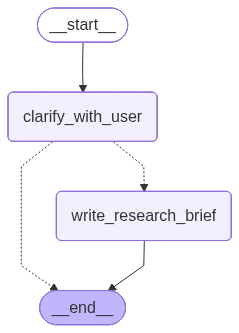

In [54]:
# Compile graph
checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [55]:
# EXECUTION / DEMO
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

result = scope.invoke({"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])
Markdown(result["research_brief"])

        Run Metrics         
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric           ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ total_messages   │ 1     │
│ human_count      │ 1     │
│ ai_count         │ 0     │
│ avg_human_length │ 58.0  │
│ avg_ai_length    │ 0.0   │
│ latency          │ 0.74  │
└──────────────────┴───────┘

         Run Metrics         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric            ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ specificity_score │ 0.0   │
│ latency           │ 1.19  │
└───────────────────┴───────┘

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ I have enough information to start researching the best coffee shops in San Francisco. I will begin the         │
│ research process now.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

        Run Metrics         
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric           ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ total_messages   │ 3     │
│ human_count      │ 2     │
│ ai_count         │ 1     │
│ avg_human_length │ 68.0  │
│ avg_ai_length    │ 125.0 │
│ latency          │ 0.68  │
└──────────────────┴───────┘

         Run Metrics         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric            ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ specificity_score │ 0.2   │
│ latency           │ 0.95  │
└───────────────────┴───────┘

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ I have enough information to start researching the best coffee shops in San Francisco. I will begin the         │
│ research process now.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ I have enough information to start researching the best coffee shops in San Francisco, focusing on coffee       │
│ quality. I will begin the research process now.                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

I want to research the best coffee shops in San Francisco, with a specific focus on coffee quality. I will consider
factors such as bean sourcing, roasting methods, and brewing techniques to assess the overall quality. I have not  
specified any constraints on price or location within San Francisco, so all options should be considered.

In [56]:
Markdown(result["research_brief"])

I want to research the best coffee shops in San Francisco, with a specific focus on coffee quality. I will consider
factors such as bean sourcing, roasting methods, and brewing techniques to assess the overall quality. I have not  
specified any constraints on price or location within San Francisco, so all options should be considered.

In [62]:
import time

def run_with_metrics(run_id, scope, messages, config, return_metrics=False):
    """
    Run the scope with metrics collection.
    If return_metrics=True, returns (result, metrics) without printing.
    Otherwise prints metrics immediately (legacy behavior).
    """
    start_time = time.time()

    # Run the scope
    result = scope.invoke({"messages": messages}, config=config)

    # Collect metrics
    metrics = {
        "run_id": run_id,
        "start_time": start_time,
        "end_time": time.time(),
        "duration_sec": round(time.time() - start_time, 3),
        "num_messages_sent": len(messages),
        "num_ai_messages": sum(1 for m in result["messages"] if m.__class__.__name__ == "AIMessage"),
        "num_human_messages": sum(1 for m in result["messages"] if m.__class__.__name__ == "HumanMessage")
    }

    if return_metrics:
        return result, metrics  # <-- silent, no print
    else:
        print("\n Metrics for this run:")
        for k, v in metrics.items():
            print(f"  {k}: {v}")
        return result


In [64]:
# ===== INTERACTIVE CHATBOT LOOP =====
thread = {"configurable": {"thread_id": "chatbot_001"}}
conversation_history = []
metrics_log = []

console.print(f"[bold green]Research Agent Chatbot started on {get_today_str()}[/bold green]")
console.print("[bold green]Type 'exit' to quit.[/bold green]\n")

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        console.print("[bold red]Chatbot session ended.[/bold red]")
        break

    # Add user message
    human_msg = HumanMessage(content=user_input)
    conversation_history.append(human_msg)

    # Show current date
    console.print(f"[bold cyan]Date: {get_today_str()}[/bold cyan]")

    # Run workflow & collect metrics silently
    result, run_metrics = run_with_metrics(
        run_id=f"turn_{len(metrics_log)+1}",
        scope=scope,
        messages=conversation_history,
        config=thread,
        return_metrics=True
    )

    # Store metrics for later
    run_metrics["turn_timestamp"] = get_today_str()
    metrics_log.append(run_metrics)

    # Display bot response
    format_messages(result['messages'])

    # Add AI messages to history
    conversation_history.extend([m for m in result['messages'] if isinstance(m, AIMessage)])

    # Show research brief if generated
    if "research_brief" in result:
        console.print("\n[bold blue]🔹 Research Brief Generated:[/bold blue]")
        display(Markdown(result["research_brief"]))


console.print("\n[bold magenta] Session Metrics Summary[/bold magenta]")
for i, m in enumerate(metrics_log, 1):
    console.print(f"\n[bold yellow]Turn {i} Metrics:[/bold yellow]")
    for k, v in m.items():
        console.print(f"{k}: {v}")


Research Agent Chatbot started on Wed Sep 17, 2025

Type 'exit' to quit.

You: best cake in bangalore


Date: Wed Sep 17, 2025

         Run Metrics         
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric           ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ total_messages   │ 15     │
│ human_count      │ 8      │
│ ai_count         │ 7      │
│ avg_human_length │ 99.75  │
│ avg_ai_length    │ 219.57 │
│ latency          │ 1.07   │
└──────────────────┴────────┘

         Run Metrics         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric            ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ specificity_score │ 0.0   │
│ latency           │ 0.54  │
└───────────────────┴───────┘

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ best cake in bangalore                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Could you please specify what kind of "report" you are looking for? For example, are you interested in a list   │
│ of the best bakeries, a specific type of cake, or something else entirely?                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ best bakeries with chocolate blueberry cake                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ You have provided enough information to start the research. I will look for the best bakeries in Bangalore that │
│ offer chocolate blueberry cake.                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ Here are the prices for the cakes at the bakeries in Bangalore that offer or are known for a chocolate          │
│ blueberry cake:  Cakeday Bakehouse: Their chocolate blueberry cake is priced at Rs. 449.  Aubree Haute          │
│ Chocolaterie: The Eggless Blueberry cake is priced at ₹ 940.  SMOOR: The Perfect Blueberry Cheesecake is priced │
│ at ₹ 1,533 for a half kilogram. The price of their blueberry crumble cake is not available online.  Liliyum     │
│ Patisserie: Their Blueberry Tea Cake is priced at Rs. 675, and their celebration Blueberry cake ranges from Rs. │
│ 1,195 to Rs. 3,295.  Please note that prices can vary based on size and customization.                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Thank you for providing the pricing details for chocolate blueberry cakes at various Bangalore bakeries. I have │
│ sufficient information to proceed with your request and will now begin the research.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ free from artifical coloring                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Thank you for the additional information. I understand you are looking for bakeries in Bangalore that offer     │
│ chocolate blueberry cake, specifically those that are free from artificial coloring. I have sufficient details  │
│ to begin my research.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ best cake in bangalore                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Thank you for the information. I have all the necessary details to research the best bakeries in Bangalore that │
│ offer chocolate blueberry cake, specifically those free from artificial coloring. I will now begin the          │
│ research.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ price rate is 500                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Thank you for providing the price range. I have sufficient information to research the best bakeries in         │
│ Bangalore that offer chocolate blueberry cake, are free from artificial coloring, and are within your specified │
│ price range of Rs. 500. I will now begin the research.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ provide me the list                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Thank you for providing all the necessary details. I have sufficient information to research the best bakeries  │
│ in Bangalore that offer chocolate blueberry cake, are free from artificial coloring, and are within your        │
│ specified price range of Rs. 500. I will now begin the research.                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ best cake in bangalore                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Thank you for providing all the necessary details. I have sufficient information to research the best bakeries  │
│ in Bangalore that offer chocolate blueberry cake, are free from artificial coloring, and are within your        │
│ specified price range of Rs. 500. I will now begin the research.                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔹 Research Brief Generated:

I am looking for the best bakeries in Bangalore that offer chocolate blueberry cake. The cake should be free from  
artificial coloring and the price should be around Rs. 500. I need a list of these bakeries.

You: exit


Chatbot session ended.

 Session Metrics Summary

Turn 1 Metrics:

run_id: turn_1

start_time: 1758104365.4538116

end_time: 1758104367.1108358

duration_sec: 1.657

num_messages_sent: 1

num_ai_messages: 8

num_human_messages: 8

turn_timestamp: Wed Sep 17, 2025